The data was obtained here: https://www.kaggle.com/datasets/nationalparkservice/park-biodiversity?resource=download

In [41]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import os

In [9]:
os.chdir('/Users/maxwellpatterson/Desktop/personal/natural-capital-footprint-impact')

In [48]:
species = pd.read_csv("new-data/biodiversity-ntlparks/species.csv")

/var/folders/5w/jm5vb2lx325d3qgftkz7xz380000gn/T/ipykernel_44387/357169691.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  species = pd.read_csv("new-data/biodiversity-ntlparks/species.csv")


In [49]:
species.describe()

,Species ID,Park Name,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status,Unnamed: 13
count,119248,119248,119248,117776,117736,119248,92101,119242,99106,94203,76306,20157,4718,5
unique,119248,56,14,554,2332,46022,35825,53,7,5,8,24,11,3
top,ACAD-1000,Great Smoky Mountains National Park,Vascular Plant,Poales,Asteraceae,Falco peregrinus,Brachythecium Moss,Approved,Present,Native,Unknown,Breeder,Species of Concern,Threatened
freq,1,6623,65221,11453,8843,56,75,86254,83278,75950,28119,12214,3843,2


In [50]:
# Check for missing values
print(species.isnull().sum())

Species ID                  0
Park Name                   0
Category                    0
Order                    1472
Family                   1512
Scientific Name             0
Common Names            27147
Record Status               6
Occurrence              20142
Nativeness              25045
Abundance               42942
Seasonality             99091
Conservation Status    114530
Unnamed: 13            119243
dtype: int64


In [51]:
# Removing column 13 which is empty
last_col = species.columns[-1]
species = species.drop(last_col, axis=1)

# Fill missing values in 'Order' and 'Family' with 'Unknown'
species['Order'].fillna('Unknown', inplace=True)
species['Family'].fillna('Unknown', inplace=True)

# Fill missing values in 'Common Names' with 'N/A'
species['Common Names'].fillna('N/A', inplace=True)

# Fill missing values in 'Record Status' with the mode (most frequent value)
species['Record Status'].fillna(species['Record Status'].mode()[0], inplace=True)

# Fill missing values in 'Occurrence' with 'Unknown'
species['Occurrence'].fillna('Unknown', inplace=True)

# Fill missing values in 'Nativeness' with 'Unknown'
species['Nativeness'].fillna('Unknown', inplace=True)

# Fill missing values in 'Abundance' with 'Unknown'
species['Abundance'].fillna('Unknown', inplace=True)

# Fill missing values in 'Seasonality' with 'Unknown'
species['Seasonality'].fillna('Unknown', inplace=True)

# Fill missing values in 'Conservation Status' with 'Unknown'
species['Conservation Status'].fillna('Stable', inplace=True)

# Encode categorical variables
species["Category"] = pd.Categorical(species["Category"])
species["Category_code"] = species["Category"].cat.codes

species["Nativeness"] = pd.Categorical(species["Nativeness"])
species["Nativeness_code"] = species["Nativeness"].cat.codes

# Print the updated DataFrame
print("\nUpdated DataFrame:")
print(species.head())


Updated DataFrame:
  Species ID             Park Name Category         Order    Family  \
0  ACAD-1000  Acadia National Park   Mammal  Artiodactyla  Cervidae   
1  ACAD-1001  Acadia National Park   Mammal  Artiodactyla  Cervidae   
2  ACAD-1002  Acadia National Park   Mammal     Carnivora   Canidae   
3  ACAD-1003  Acadia National Park   Mammal     Carnivora   Canidae   
4  ACAD-1004  Acadia National Park   Mammal     Carnivora   Canidae   

          Scientific Name                                       Common Names  \
0             Alces alces                                              Moose   
1  Odocoileus virginianus  Northern White-Tailed Deer, Virginia Deer, Whi...   
2           Canis latrans                             Coyote, Eastern Coyote   
3             Canis lupus        Eastern Timber Wolf, Gray Wolf, Timber Wolf   
4           Vulpes vulpes  Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...   

  Record Status     Occurrence  Nativeness Abundance Seasonality  \
0   

In [52]:
# Check for missing values of cleaned df
print(species.isnull().sum())

Species ID             0
Park Name              0
Category               0
Order                  0
Family                 0
Scientific Name        0
Common Names           0
Record Status          0
Occurrence             0
Nativeness             0
Abundance              0
Seasonality            0
Conservation Status    0
Category_code          0
Nativeness_code        0
dtype: int64


In [67]:
# Print unique values in the 'Nativeness' column
print("Unique values in 'Nativeness':")
print(species['Nativeness'].unique())
print()

# Print unique values in the 'Abundance' column
print("Unique values in 'Abundance':")
print(species['Abundance'].unique())
print()

# Print unique values in the 'Seasonality' column
print("Unique values in 'Seasonality':")
print(species['Seasonality'].unique())
print()

# Print unique values in the 'Conservation Status' column
print("Unique values in 'Conservation Status':")
print(species['Conservation Status'].unique())

Unique values in 'Nativeness':
['Native', 'Not Native', 'Unknown', 'Not Confirmed', 'Present']
Categories (5, object): ['Native', 'Not Confirmed', 'Not Native', 'Present', 'Unknown']

Unique values in 'Abundance':
['Rare' 'Abundant' 'Common' 'Unknown' 'Uncommon' 'Occasional' 'Not Native'
 'Native']

Unique values in 'Seasonality':
['Resident' 'Unknown' 'Breeder' 'Vagrant' 'Migratory' 'Rare'
 'Breeder, Migratory' 'Breeder, Summer' 'Migratory, Vagrant' 'Uncommon'
 'Breeder, Resident' 'Migratory, Winter' 'Breeder, Winter' 'Winter'
 'Resident, Winter' 'Summer, Vagrant' 'Breeder, Resident, Summer'
 'Resident, Summer' 'Summer' 'Breeder, Resident, Migratory, Summer'
 'Breeder, Resident, Summer, Winter' 'Migratory, Summer' 'Winter, Vagrant'
 'Common']

Unique values in 'Conservation Status':
[11  8  1  3  9 10  6  2  5  7  0  4]


In [70]:
# Filter the dataset to keep only rows with 'Occurrence' as 'Present'
species_filtered = species[species['Occurrence'] == 'Present']

# Check for missing values in the filtered dataset
print("Missing values in the original dataset:")
print(species[species['Occurrence'] == 'Present'].sum())

Missing values in the original dataset:


TypeError: 'Categorical' with dtype category does not support reduction 'sum'

Distribution of species across categories:
Category
Vascular Plant         65221
Bird                   14601
Insect                 14349
Fungi                   6203
Nonvascular Plant       4278
Fish                    3956
Mammal                  3867
Invertebrate            1566
Reptile                 1343
Algae                    976
Slug/Snail               787
Spider/Scorpion          776
Amphibian                743
Crab/Lobster/Shrimp      582
Name: count, dtype: int64

Distribution of species across nativeness:
Nativeness
Native           75950
Unknown          32146
Not Native       11095
Present             53
Not Confirmed        4
Name: count, dtype: int64


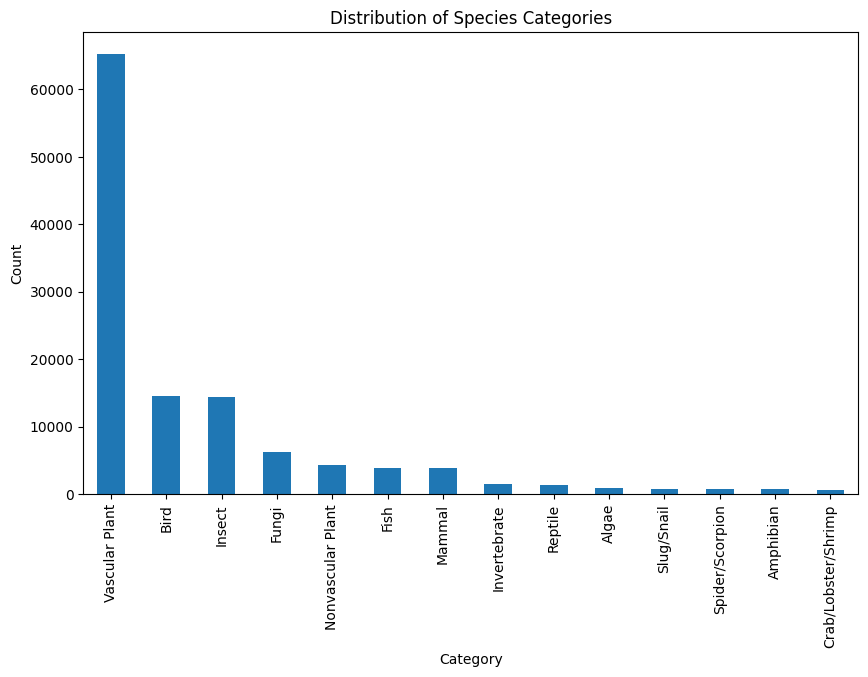

In [53]:
# Analyze the distribution of species across categories
print("Distribution of species across categories:")
print(species["Category"].value_counts())

# Analyze the distribution of species across nativeness
print("\nDistribution of species across nativeness:")
print(species["Nativeness"].value_counts())

# Visualize the distribution of species categories
plt.figure(figsize=(10, 6))
species["Category"].value_counts().plot(kind="bar")
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of Species Categories")
plt.show()

In [57]:
# Select relevant features for modeling
features = ["Category_code", "Nativeness_code", "Abundance", "Seasonality"]
target = "Conservation Status"

In [58]:
# Encode the target variable
label_encoder = LabelEncoder()
species[target] = label_encoder.fit_transform(species[target])

# Define the Bayesian model
with pm.Model() as model:
    # Define priors for the model parameters
    intercept = pm.Normal("intercept", mu=0, sd=10)
    beta_category = pm.Normal("beta_category", mu=0, sd=10)
    beta_nativeness = pm.Normal("beta_nativeness", mu=0, sd=10)
    
    # Define the likelihood function
    theta = intercept + beta_category * species["Category_code"] + beta_nativeness * species["Nativeness_code"]
    y = pm.Bernoulli("y", logit_p=theta, observed=species[target])
    
    # Run the MCMC sampler
    trace = pm.sample(1000, tune=1000)

/Users/maxwellpatterson/Desktop/personal/natural-capital-footprint-impact/rich/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_nativeness, beta_category, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [59]:
# Print the summary of the MCMC trace
print(pm.summary(trace))

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/maxwellpatterson/Desktop/personal/natural-capital-footprint-impact/rich/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept        9.026  0.979   7.210   10.773      0.029    0.021    1222.0   
beta_category    0.322  0.124   0.092    0.555      0.004    0.003    1263.0   
beta_nativeness -0.487  0.248  -0.978   -0.053      0.007    0.005    1336.0   

                 ess_tail  r_hat  
intercept          1173.0    1.0  
beta_category      1381.0    1.0  
beta_nativeness    1158.0    1.0  


/Users/maxwellpatterson/Desktop/personal/natural-capital-footprint-impact/rich/lib/python3.8/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


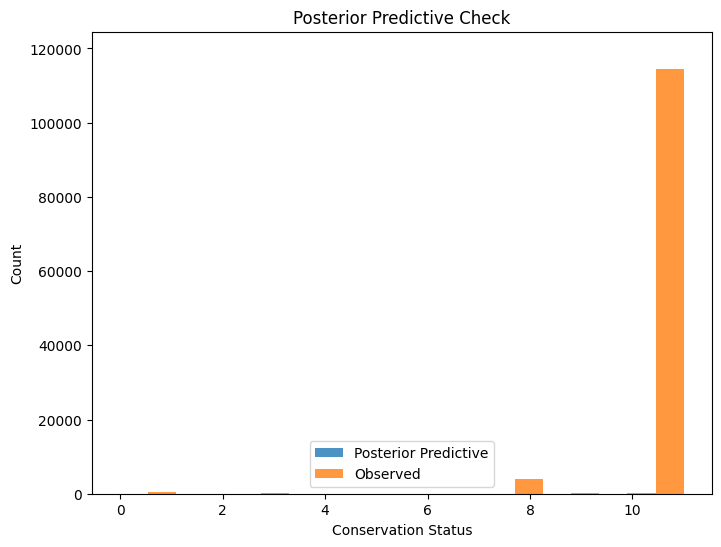

In [60]:
# Perform posterior predictive checks
with model:
    ppc = pm.sample_posterior_predictive(trace, samples=100)
    
# Visualize the posterior predictive distribution
plt.figure(figsize=(8, 6))
plt.hist(ppc["y"].mean(axis=0), bins=20, alpha=0.8, label="Posterior Predictive")
plt.hist(species[target], bins=20, alpha=0.8, label="Observed")
plt.xlabel("Conservation Status")
plt.ylabel("Count")
plt.title("Posterior Predictive Check")
plt.legend()
plt.show()

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/maxwellpatterson/Desktop/personal/natural-capital-footprint-impact/rich/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


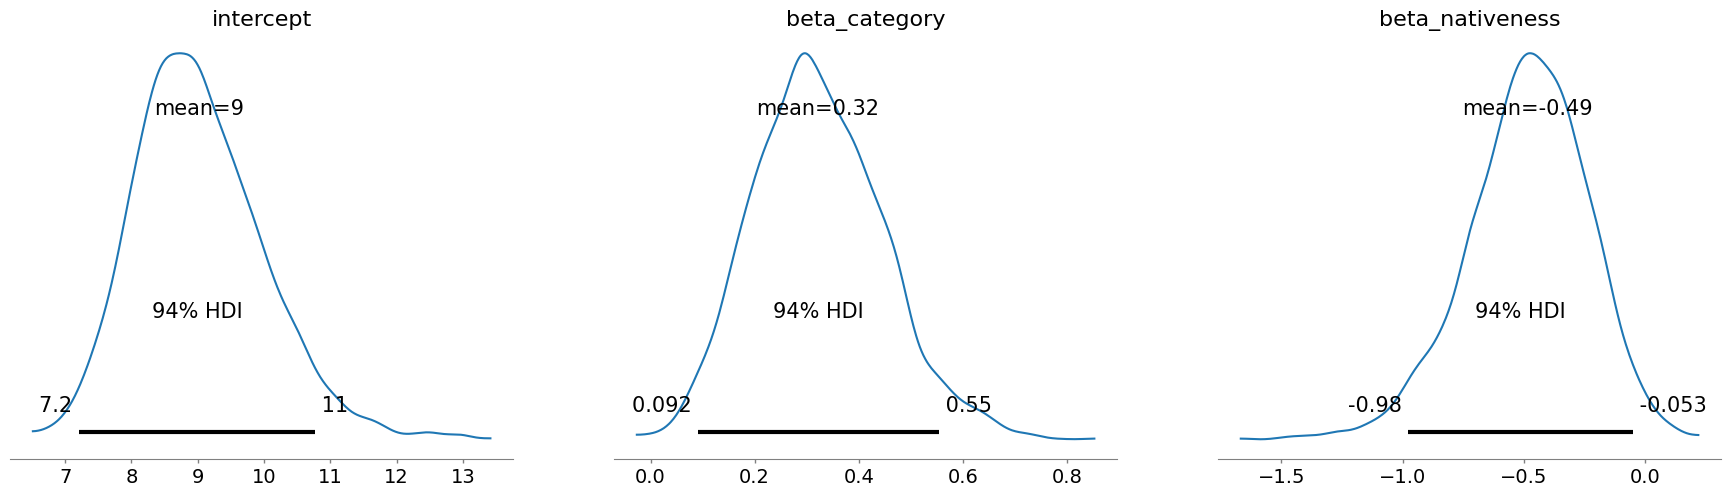

In [61]:
# Plot the posterior distributions of the model parameters
pm.plot_posterior(trace, var_names=["intercept", "beta_category", "beta_nativeness"])
plt.show()

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/maxwellpatterson/Desktop/personal/natural-capital-footprint-impact/rich/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


Intercept (Baseline Log-Odds):
9.026 7.21 10.773

Category Coefficients:
Continuous Variable: 0.322 (0.092, 0.555)

Nativeness Coefficients:
Continuous Variable: -0.487 (-0.978, -0.053)



/Users/maxwellpatterson/Desktop/personal/natural-capital-footprint-impact/rich/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


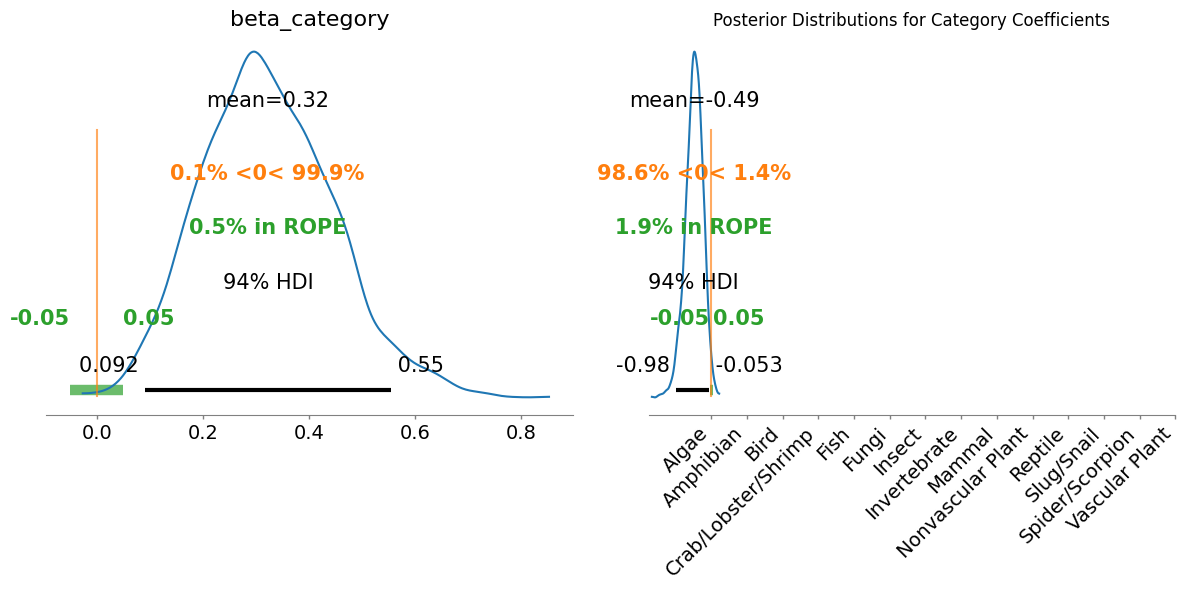

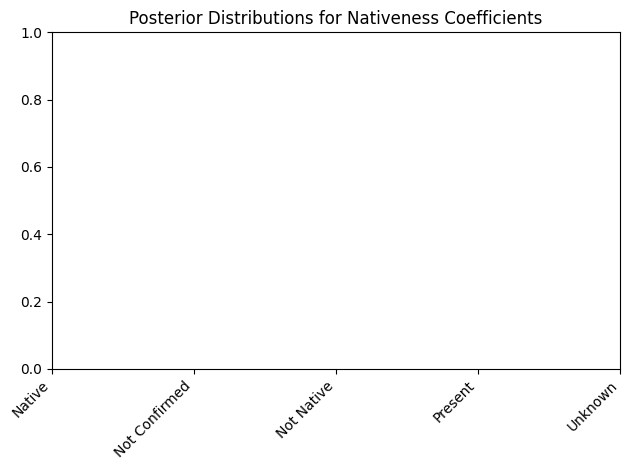

In [65]:
import pandas as pd

# Assuming you have the 'species' dataframe and the fitted 'trace' from PyMC3

# Map category codes to category names
category_map = {c: name for c, name in enumerate(species['Category'].cat.categories)}

# Map nativeness codes to nativeness names
nativeness_map = {c: name for c, name in enumerate(species['Nativeness'].cat.categories)}

# Get the summary statistics
summary = pm.summary(trace, var_names=['intercept', 'beta_category', 'beta_nativeness'])

# Print the intercept
print("Intercept (Baseline Log-Odds):")
print(summary['mean']['intercept'], summary['hdi_3%']['intercept'], summary['hdi_97%']['intercept'])
print()

# Print the category coefficients
print("Category Coefficients:")
if isinstance(summary['mean']['beta_category'], (float, np.float64)):
    # If beta_category is a single value, print it directly
    coef = summary['mean']['beta_category']
    lower, upper = summary['hdi_3%']['beta_category'], summary['hdi_97%']['beta_category']
    print(f"Continuous Variable: {coef} ({lower}, {upper})")
else:
    # If beta_category is a vector, iterate over it
    for code, coef in enumerate(summary['mean']['beta_category']):
        category_name = category_map[code]
        lower, upper = summary['hdi_3%']['beta_category'][code], summary['hdi_97%']['beta_category'][code]
        print(f"{category_name}: {coef} ({lower}, {upper})")
print()

# Print the nativeness coefficients
print("Nativeness Coefficients:")
if isinstance(summary['mean']['beta_nativeness'], (float, np.float64)):
    # If beta_nativeness is a single value, print it directly
    coef = summary['mean']['beta_nativeness']
    lower, upper = summary['hdi_3%']['beta_nativeness'], summary['hdi_97%']['beta_nativeness']
    print(f"Continuous Variable: {coef} ({lower}, {upper})")
else:
    # If beta_nativeness is a vector, iterate over it
    for code, coef in enumerate(summary['mean']['beta_nativeness']):
        nativeness_name = nativeness_map[code]
        lower, upper = summary['hdi_3%']['beta_nativeness'][code], summary['hdi_97%']['beta_nativeness'][code]
        print(f"{nativeness_name}: {coef} ({lower}, {upper})")
print()

# Plot the posterior distributions with category/nativeness labels
pm.plot_posterior(trace, var_names=['beta_category', 'beta_nativeness'], ref_val=0,
                  rope=(-0.05, 0.05), figsize=(12, 6))
ax = plt.gca()
ax.set_xticks([i for i in range(len(category_map))])
ax.set_xticklabels([category_map[i] for i in sorted(category_map)], rotation=45, ha='right')
plt.title('Posterior Distributions for Category Coefficients')
plt.tight_layout()
plt.show()

ax = plt.gca()
ax.set_xticks([i for i in range(len(nativeness_map))])
ax.set_xticklabels([nativeness_map[i] for i in sorted(nativeness_map)], rotation=45, ha='right')
plt.title('Posterior Distributions for Nativeness Coefficients')
plt.tight_layout()
plt.show()

In [66]:
species.head()

,Species ID,Park Name,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status,Category_code,Nativeness_code
0,ACAD-1000,Acadia National Park,Mammal,Artiodactyla,Cervidae,Alces alces,Moose,Approved,Present,Native,Rare,Resident,11,8,0
1,ACAD-1001,Acadia National Park,Mammal,Artiodactyla,Cervidae,Odocoileus virginianus,"Northern White-Tailed Deer, Virginia Deer, Whi...",Approved,Present,Native,Abundant,Unknown,11,8,0
2,ACAD-1002,Acadia National Park,Mammal,Carnivora,Canidae,Canis latrans,"Coyote, Eastern Coyote",Approved,Present,Not Native,Common,Unknown,8,8,2
3,ACAD-1003,Acadia National Park,Mammal,Carnivora,Canidae,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Approved,Not Confirmed,Native,Unknown,Unknown,1,8,0
4,ACAD-1004,Acadia National Park,Mammal,Carnivora,Canidae,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",Approved,Present,Unknown,Common,Breeder,11,8,4
